In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sci
from scipy.integrate import simps

from FEM_setup import fem_solver, make_partition,Psi_0,Psi_1,Psi_2,map_to_element_k
from NumSolverForProblem2c import solve_optimal_control_1d

In [3]:

def solve_poisson_full(f, N):
    # Reconstruct full solution with u(0)=u(1)=0.
    u_interior = fem_solver(f, N, dirichlet=True)
    u_full = np.zeros(2*N+1)
    u_full[1:-1] = u_interior
    return u_full


def L2_error(u_exact, u_fem, N):
    """
    Computes the L2 error between the FEM solution u_fem and the exact solution.
    The FEM solution is piecewise quadratic on each element with global nodes at indices
    [2*k, 2*k+1, 2*k+2]. Integration is performed using Simpson's rule via scipy.integrate.simps.
    """
    x, h = make_partition(N)
    error_sq = 0.0
    xi_vals = np.array([0, 0.5, 1])
    
    for k in range(N):
        i0, i1, i2 = 2*k, 2*k+1, 2*k+2
        x0 = x[i0]
        # Evaluate FEM solution on the element at quadrature points:
        u_local = (u_fem[i0] * Psi_0(xi_vals) +
                   u_fem[i1] * Psi_1(xi_vals) +
                   u_fem[i2] * Psi_2(xi_vals))
        # Map reference points to physical element:
        x_vals = map_to_element_k(x0, h, xi_vals)
        u_ex = u_exact(x_vals)
        # Compute the squared error on the element using Simpson's rule:
        local_error_sq = simps((u_ex - u_local)**2, x_vals)
        error_sq += local_error_sq

    return np.sqrt(error_sq)







In [4]:
def f_test(x):
    return np.pi**2 * np.sin(np.pi*x) # 2.0
def u_exact(x):
    
    return np.sin(np.pi*x) #x*(1-x). 

def f1(x):
    '''source function f(x) = 1'''
    return np.ones_like(x)
def exact1(x):
    return 1/2*x*(1-x)

def f2(x):
    return -np.exp(-x)*(np.sin(np.pi*x)*(1-np.pi**2) - 2*np.pi*np.cos(np.pi*x))
    
def exact2(x):
    return np.exp(-x)*(np.sin(np.pi*x))

In [5]:

def main():
    # List of number of elements for the convergence study.
    Ns = [4, 8, 16, 32, 64, 128, 500, 1000]
    errors = []
    hs = []
    
    print("Convergence study for Quadratic FEM (Problem 1b)")
    for N in Ns:
        u_fem = solve_poisson_full(f2, N)
        err = L2_error(exact2, u_fem, N)
        errors.append(err)
        hs.append(1.0 / N)
        # print(f"N = {N:3d} elements, h = {1.0/N:8.5f}, L2 error = {err:12.5e}")
    
    # Compute empirical convergence rates.
    for i in range(1, len(errors)):
        rate = np.log(errors[i] / errors[i-1]) / np.log(hs[i] / hs[i-1])
        # print(f"Empirical rate between N={Ns[i-1]} and N={Ns[i]}: {rate:5.3f}")
    
    p, C = np.polyfit(np.log(hs), np.log(errors), 1)
    # print(f"Estimated overall convergence order: {p:5.3f}")
    
    # Plot convergence: log-log plot of h vs L2 error.
    plt.figure(figsize=(8, 6))
    plt.loglog(hs, errors, 'ro-', label='$L^2$ error')
    
    # Plot a reference line with slope 3 (since we expect O(h^3) convergence).
    h_ref = np.linspace(min(hs), max(hs), 100)
    # Set the constant so that the reference line goes through the last data point.
    C = errors[-1] / (hs[-1]**3)
    plt.loglog(h_ref, C * h_ref**3, 'k--', label='$O(h^3)$')
    
    plt.xlabel('h (element size)')
    plt.ylabel('$L^2$ error')
    plt.title(f'Convergence of Quadratic FEM in $L^2$-norm, nummerical order: {p}')
    plt.legend()
    plt.show()


Convergence study for Quadratic FEM (Problem 1b)


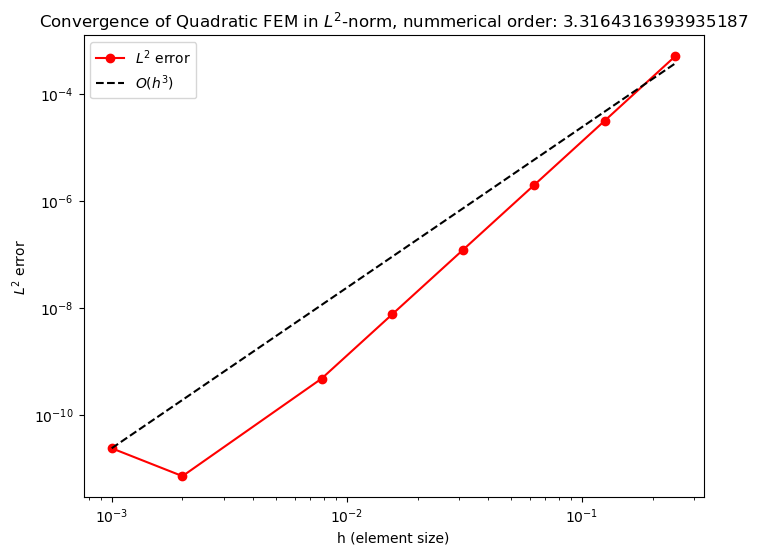

In [6]:
if __name__ == "__main__":
    main()

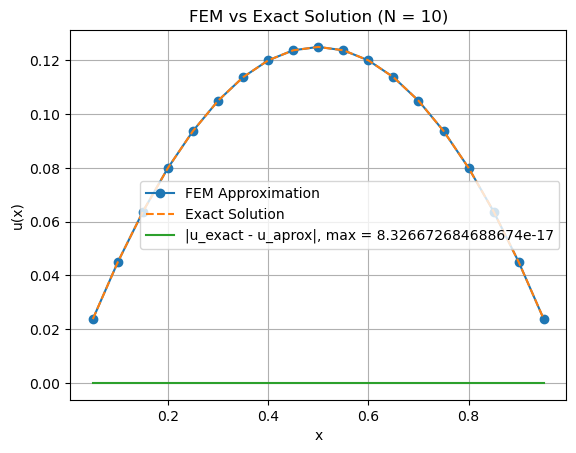

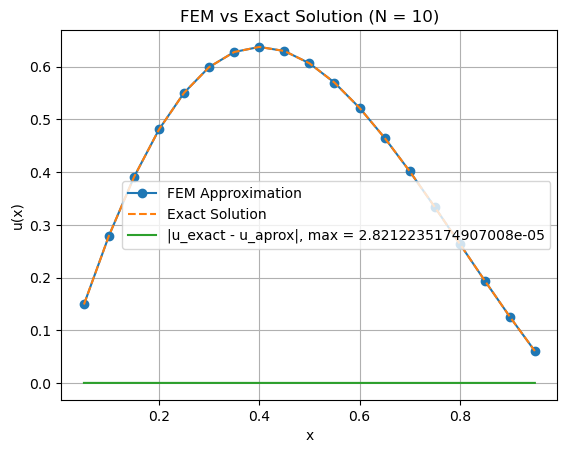

In [7]:
 def plot_FEM_and_exact(u_aprox, u_exact, N, direchlet=True):
    '''
    Plots the approximated FEM solution against the exact solution.
    Plots absolute error and shows max norm of errors

    input:
    - u_aprox: solution from FEM (assumed to be full vector of length 2N+1)
    - u_exact: callable exact solution u(x)
    - N: number of elements
    '''

    x_nodes = np.linspace(0, 1, 2*N + 1)  # FEM global nodes (where u_aprox is defined)
    # print(x_nodes, x_nodes[1:-1])
    exact_values = u_exact(x_nodes) 
    # print(exact_values.shape)
    if direchlet:
        x_nodes = x_nodes[1:-1]
    exact_values = u_exact(x_nodes)   # Evaluate exact solution at same points
    # print(exact_values.shape)
    errors = np.abs(exact_values - u_aprox)
    
    plt.plot(x_nodes, u_aprox, 'o-', label='FEM Approximation')
    plt.plot(x_nodes, exact_values, '--', label='Exact Solution')
    plt.plot(x_nodes, errors, label = f'|u_exact - u_aprox|, max = {np.max(errors)}')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title(f'FEM vs Exact Solution (N = {N})')
    plt.grid(True)
    plt.legend()
    plt.show()


#tests: 
u1 = fem_solver(f1,10)
plot_FEM_and_exact(u1, exact1, 10)

u2 = fem_solver(f2, 10)
plot_FEM_and_exact(u2, exact2, 10)


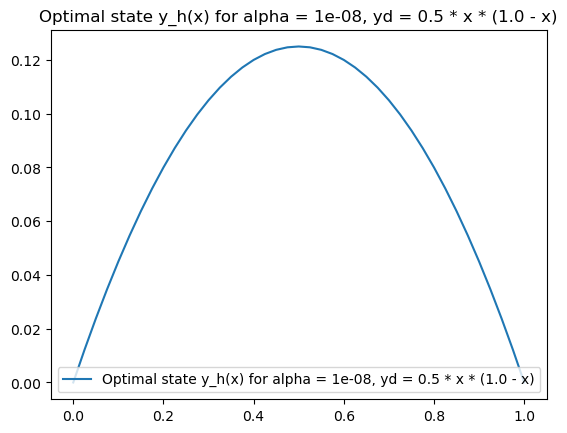

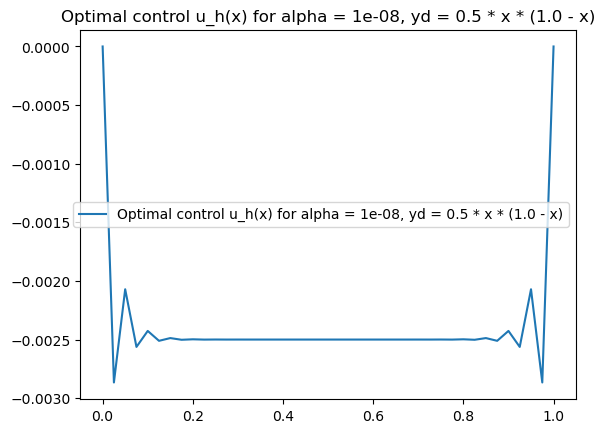

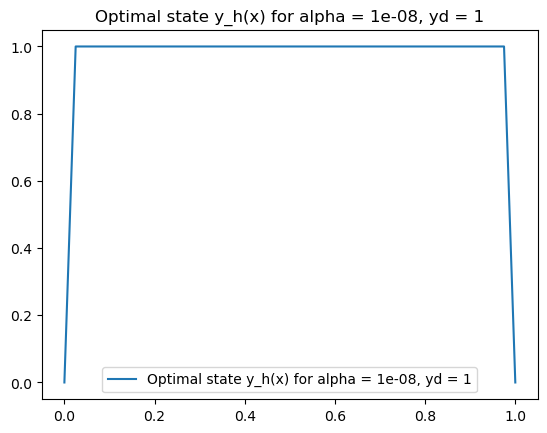

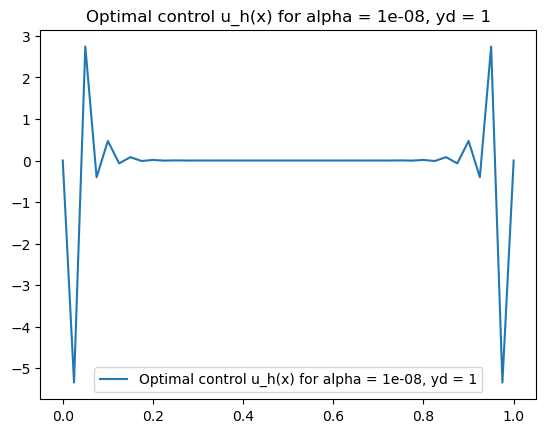

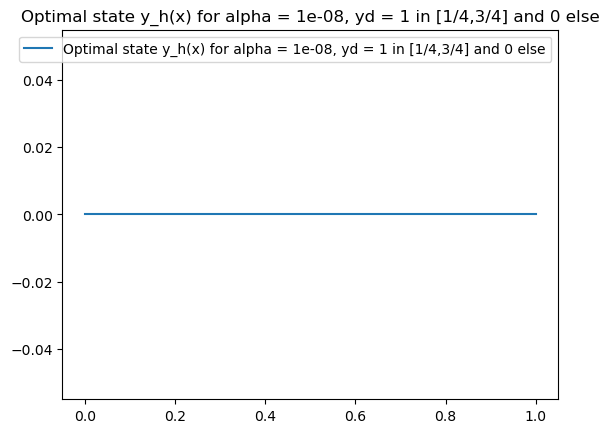

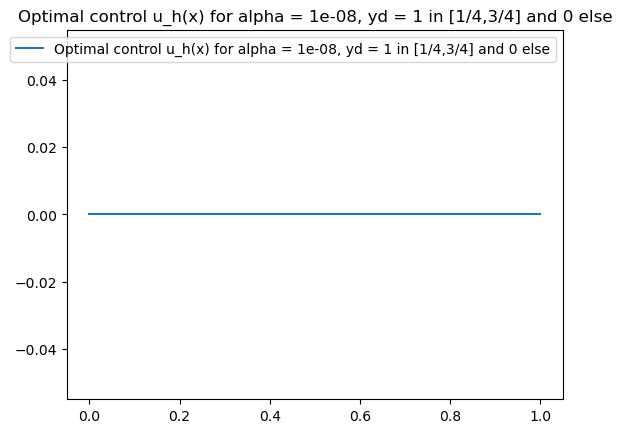

In [8]:
def plot_solution(nodes, y, label_str="y_h(x)"):
    """
    Plot a piecewise-quadratic function y given by the interior DOFs 'y'
    on the mesh 'nodes'. We'll just do a naive approach:
    - Rebuild a full array of length = 2*N+1, inserting boundary=0 at both ends.
    - Then do a simple plt.plot.
    """
    full_sol = np.zeros(len(nodes))
    boundary0 = 0
    boundary1 = len(nodes)-1
    
    # Fill interior
    ndofs = len(y)
    idx = 0
    for j in range(len(nodes)):
        if j==boundary0 or j==boundary1:
            full_sol[j] = 0.0  # boundary condition
        else:
            full_sol[j] = y[idx]
            idx += 1
    
    # Now just do a plain plot
    plt.figure()
    plt.plot(nodes, full_sol, label=label_str)
    plt.title(label_str)
    plt.legend()
    plt.show()

def y_d_function(x):
   return 0.5 * x * (1.0 - x)

def y_d2_function(x):
    return np.ones_like(x)

def y_d3_function(x): 
    if x.any()>=1/4 and x.any()<=3/4:
        return np.ones_like(x)
    else:
        return np.zeros_like(x)
    
num_elems = 20    # more elements => finer mesh
alpha = 1e-8  # try changing alpha
nodes, y_sol, u_sol, lam_sol = solve_optimal_control_1d(y_d_function,num_elems, alpha)
    
    # Plot state y_h
plot_solution(nodes, y_sol, label_str=(f"Optimal state y_h(x) for alpha = {alpha}, yd = 0.5 * x * (1.0 - x)"))
    
    # Plot control u_h
plot_solution(nodes, u_sol, label_str=(f"Optimal control u_h(x) for alpha = {alpha}, yd = 0.5 * x * (1.0 - x)"))

nodes, y_sol2, u_sol2, lam_sol2 = solve_optimal_control_1d(y_d2_function,num_elems, alpha)
    
    # Plot state y_h
plot_solution(nodes, y_sol2, label_str=(f"Optimal state y_h(x) for alpha = {alpha}, yd = 1"))
    
    # Plot control u_h
plot_solution(nodes, u_sol2, label_str=(f"Optimal control u_h(x) for alpha = {alpha}, yd = 1"))

nodes, y_sol3, u_sol3, lam_sol3 = solve_optimal_control_1d(y_d3_function,num_elems, alpha)
    
    # Plot state y_h
plot_solution(nodes, y_sol3, label_str=(f"Optimal state y_h(x) for alpha = {alpha}, yd = 1 in [1/4,3/4] and 0 else"))
    
    # Plot control u_h
plot_solution(nodes, u_sol3, label_str=(f"Optimal control u_h(x) for alpha = {alpha}, yd = 1 in [1/4,3/4] and 0 else"))
